# Overview of DICOM toolbox

This toolbox describes the tools developed to load DICOM files and ROIs from Siemens Inveon image aquistion system. The reason this toolbox has been developed is because the ROIs cannot be read by other packages such as simpleITK, which is necessary to incorporate them into a deep learning workflow.

Currently the toolbox contains the following core functionalities:
 - Loading CT and PET images from dicom files with several options
 - Extracting ROIs from RTSTRUCTs produced by Inveon
 - Filling the ROIs contours into filled coordinates or a binary mask
 - Simple but effective slice viewer, which can take both ROI coordinates and two 3D volumes
 


## readDicom function

This function takes the root folder of the scan as input, and returns the volume along with the positions in the coordinate system of the slices.

The following is the header and return funtion of readDicom():

```python
def readDicom(dicomPath, shift_correct=[0,0,0], shift_units='pixels', rescale_units=True, window=None):
    '''
    Function for reading dicom files from a directory
    Input: 
        - dicomPath:        To the folder containing the dicom data
        - shift_correct:    Correction in the x, y, and z plane
        - shift_units:      Units of the shift correction
        - rescale_units:    Boolean for whether the image should be converted to it's original units
        - window:           Window to be applied to the image 
    Output: 
        - a 3D matrix contatining the image data
        - a list with the x, y and z coordinates of the image values
        - a list of the x, y and z coordinates of the patient position of each frame
    '''
    
    ...
    
    return ArrayDicom, patient_orientation, patient_position
```



In [1]:
import numpy as np
import os
from load_dicom import readDicom, extractROIs, multi_slice_viewer, fillRoi

# This loads the a CT volumes and windows it between -400 and 400 HU 
root = './Mus01L_Mus02R/CT scan_dicom'
ArrayDicom, patient_orientation, patient_position = readDicom(root, rescale_units=True, window=[-400, 400])


rescale conversion: True
Window: [-400, 400]
pixel spacing (0.104996, 0.104996, 0.104996)
Loading image data..
0 / 960
100 / 960
200 / 960
300 / 960
400 / 960
500 / 960
600 / 960
700 / 960
800 / 960
900 / 960
The coordinate system was shift corrected: [0.00,0.00,0.00] mm
done.



## extractROIs and fillRoi

These functions are made for extracting the ROIs from a DICOM file written by the Inveon software. Inveon uses the following private tags to re-create the 3D coordinatesystem for the ROIs. Notice it **doesn't** use the patient direction:

 - (0007d)(1001): Pixel dimensions
 - (0007d)(1002): pixel spacing (slice thickness)
 - (0007d)(1003): Patient position
 
 The extractROIs function returns a dict, where the keys are 0,1,2... up to N number of ROIs. Each value is another dict with the keys: 
 - name: The name of the ROI 
 - coords_pix: The coordinates in pixel placement. This is a list of numpy arrays with coordinates for each slice  
 - coords_mm: The coordinates in mm. This is a list of numpy arrays with coordinates for each slice  

So: rois[0]['coords_pix'] will be the first ROI and in pixel corrdinates. This is a list, where each entry is numpy array with coordinates for each slice.

The following is the header and return funtions of extractROIs() and fillRoi():

```python
def extractROIs(file_path, patient_orientation=None, coordsCT=None, verbose=False, return_spacing=False, reverse_axis=[False]):
    '''
    Extract rois from a dicom file and fills the outline with points. If no coordsCT is given,
    It's assumed that the ROI is from Inveon and hence the positions are stored in private tags
    Input:
        file_path:                  Path to the .dcm file with the ROIs                
        patient_orientation:        Orientation of the patient coordinate system, list with 6 entries: x,y and 
                                    z for x axis and y axis
        coordsCT:                   Coordinate system of the patient
        verbose:                    Whether to print out all the rois at 
                                    the end
        reverse_axis:               Which to reverse the positive direction of 
    Output:
        rois:                       dict with the name, coords_mm and coords_pix
    '''
    ...
    
    if return_spacing:
        return rois, ConstPixelSpacing
    else:
        return rois 
```


```python
def fillRoi(points, make_mask=False, size=None, correct_border=False):
    '''
    Wrapper for calling function to space fill the ROIs  
    Input:
        points:             Nx2 numpy array of x,y coordinates
        make_mask:          Make a binary mask of the coordinates with specified size
        size:               size of binary mask (tuple), if make_mask is True
        correct_border:     whether to weight the border area by center placed coordinates
    Output:
        filled_poits:   filled points either as x,y coordinates or as binary mask
       
    ...
    '''   
    if make_mask:
        ...
        return mask
    else:
        return filled_points.astype(np.int16)
```

In [2]:
roi_root = r'C:\Users\Malte\Documents\CMI\python\notebook_for_github\Mus01L_Mus02R'

# Extract the rois from the DICOM 
rois = extractROIs(os.path.join(roi_root, '1.2.826.0.1.3417726.3.338535.20160607080856980.dcm'), reverse_axis=['y'])

# Extract the left and right tumor rois
for i in range(len(rois)):
    if 'tumor' in rois[i]['name'].lower() and 'L' in rois[i]['name']:
        roi_L = rois[i]            
    elif 'tumor' in rois[i]['name'].lower() and 'R' in rois[i]['name']:
        roi_R = rois[i]

# Find the slice index of the ROIs 
roi_idx_L = [int(coords[0,2]) for coords in roi_L['coords_pix']]
roi_idx_R = [int(coords[0,2]) for coords in roi_R['coords_pix']]

# pre-allocate
mask_L = np.zeros(ArrayDicom.shape, dtype=np.int8)
mask_R = np.zeros(ArrayDicom.shape, dtype=np.int8)

# Fill the rois and put the in the mask
for i, idx in enumerate(roi_idx_L):
    mask_L[:,:,idx] = fillRoi(roi_L['coords_pix'][i][:,:2], make_mask=True, size=ArrayDicom.shape[:2])

for i, idx in enumerate(roi_idx_R):
    mask_R[:,:,idx] = fillRoi(roi_R['coords_pix'][i][:,:2], make_mask=True, size=ArrayDicom.shape[:2])

# merge the mask into one mask
mask_R_L = mask_R + mask_L


loading rois..
Reversed y-axis
1 / 36
10 / 36
20 / 36
30 / 36


## multi_slice_viewer function
This function is a viewer for the loaded volumes. It can load up to two volumes at the same time (have to be the same size) and a list of several ROIs (coordinates in pixels). The ROIs are expected to be a list, where each element is a list with ROIs, as they are returned by the extractROIs function.

The up and down keys ascend and decend through the slices, and the j and k keys increase and decrease the alpha (opacity) of the second volume.

The following is the header and return funtions of multi_slice_viewer class:

```python
class multi_slice_viewer:
    '''
    Inputs:
        volume:             3D volume to be viewed. The last dimension is expected to be the z-dimension
        second_volume:      Optional second 3D volume to be viewed. The last dimension is expected to be the
                            z-dimension
        cmap:               colormap to be used on the first volume
        second_cmap:        colormap to be used on the second volume
        alpha:              Initial alpha of the second volume
        rois:               List of ROIs coordinates in pixel. Each list entry should be a new list with arrays 
                            for each slice
        start_slice:        Which slice to start out on
        shift_correct:      Shift ROI coordinates (in pixels)
        window:             Max and min value to be displayed for the first volume 
        second_window:      Max and min value to be displayed for the second volume
        orientation:        Can be 'axial', 'coronal' or 'sagittal'
    Controls:
        Up and down keys:   Ascend or descent through the stack of slices
        j and k keys:       Increase or decrease the alpha value, when two volumes are present
    '''
    def __init__(self,volume, second_volume=None, second_cmap='hot', alpha=0.5, rois=None,
                 start_slice=450,shift_correct=[0,0], window=[None, None], second_window=[None, None],
                 cmap='gray', orientation='axial'):```



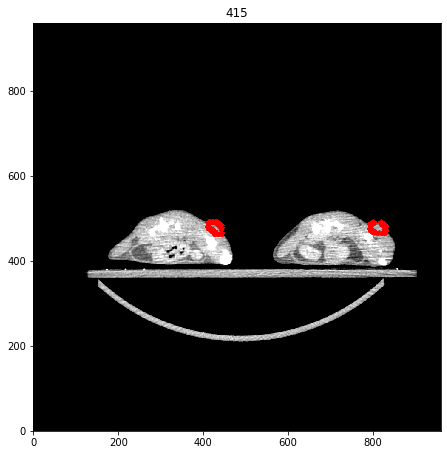

In [5]:
# The ROIs can be shown either as a 3D volume or as the coordinates in pixels. The following is an example
# of using the coordinates option 
vi = multi_slice_viewer(ArrayDicom, rois=[roi_L['coords_pix'], roi_R['coords_pix']], cmap='gray', second_cmap='jet',second_window=[0,1],
                       start_slice = 415, orientation='axial')

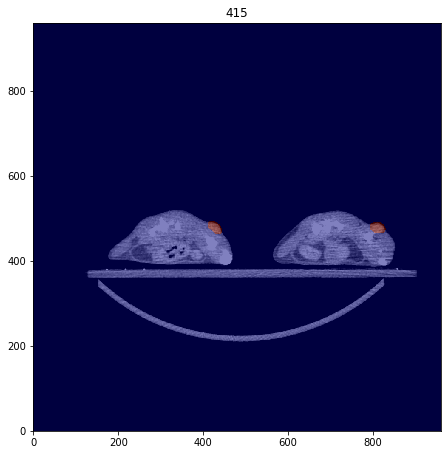

In [6]:
# And here we use the 3D volume ROI
vi = multi_slice_viewer(ArrayDicom, second_volume=mask_R_L, cmap='gray', second_cmap='jet',second_window=[0,1],
                       start_slice = 415, orientation='axial')



